In [1]:
from qaravan.applications import magnetization, trotter_dm_sim, trotter_sv_sim
from qaravan.core import TFI, QubitNoise
from plotting import *
import numpy as np

# Thermal noise simulation over time

In [8]:
n = 6

ham = TFI(n, 1, 0.75)
step_size = 0.1 
max_steps = 500

t1 = 100
t2 = 75
one_time = 40/1000 
two_time = 500/1000
channel = QubitNoise(t1, t2, one_time, two_time)

op = magnetization(n)

In [9]:
noiseless_exp = trotter_sv_sim(ham, step_size, max_steps, op)
noisy_exp = trotter_dm_sim(ham, step_size, max_steps, channel, op)

100%|██████████| 500/500 [00:04<00:00, 107.12it/s]


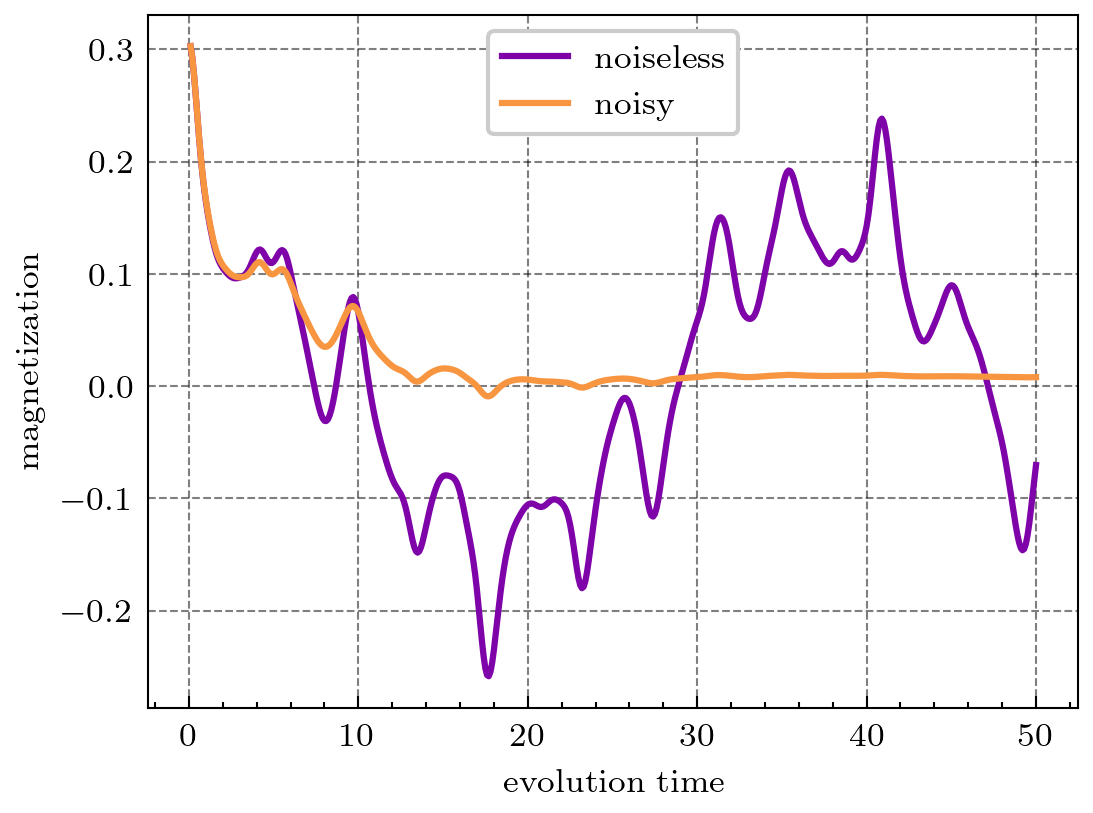

In [17]:
set_style(grid=True)
times = [step_size * (i+1) for i in range(max_steps)]

colors = plt.cm.plasma(np.linspace(0.25,0.75,2))
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(times, noiseless_exp, label='noiseless', color=colors[0])
ax.plot(times, noisy_exp, label='noisy', color=colors[1])
ax.set_xlabel('evolution time')
ax.set_ylabel('magnetization')
ax.legend(loc='upper center')

plt.savefig('tfi_noisy_sim.pdf', bbox_inches='tight')


# Pauli noise simulation with Monte Carlo

In [6]:
from qaravan.core import TFI, random_pauli_channel
from qaravan.tensorQ import DensityMatrixSim, MonteCarloSim
from qaravan.applications import magnetization
import numpy as np

In [11]:
n = 4

ham = TFI(n, 1, 0.75)
step_size = 1
num_steps = 1
circ = ham.trotter_circ(step_size, num_steps)

op = magnetization(n)
channel = random_pauli_channel(n)

sim = DensityMatrixSim(circ, nm=channel)
noisy_exp = sim.global_expectation(op)

sim2 = MonteCarloSim(circ, nm=channel)
samples = [sim2.expectation_sample(op) for _ in range(50000)]

In [33]:
reps = 50
sample_size_opts = np.logspace(1, 3.8, num=10, dtype=int)

err_mean = []
err_std = []
for sample_size in sample_size_opts:
    est_err_rep = []
    for _ in range(reps):
        subsample = np.random.choice(samples, size=sample_size, replace=False)
        est_err_rep.append(np.abs(np.mean(subsample) - noisy_exp))

    err_mean.append(np.mean(est_err_rep))
    err_std.append(np.std(est_err_rep))

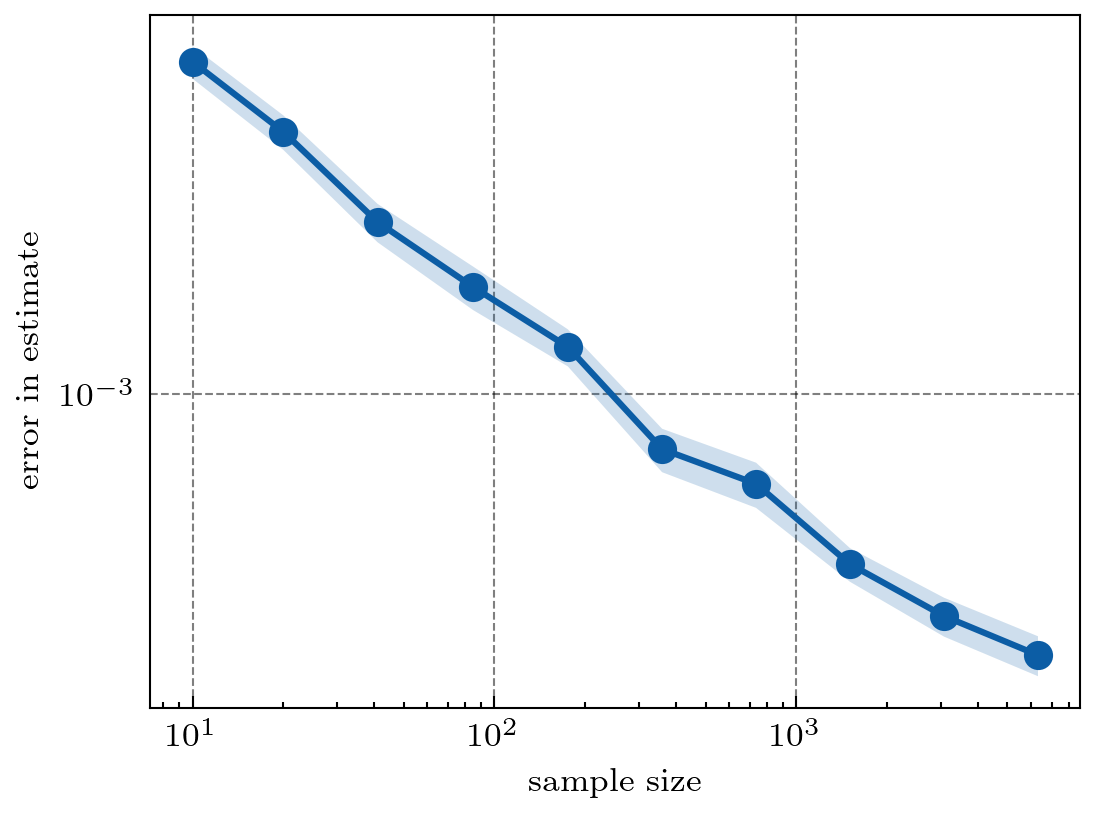

In [35]:
from plotting import *

set_style(grid=True)
colors = plt.cm.plasma(np.linspace(0.25,0.75,2))
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(sample_size_opts, err_mean, marker='o')
ax.fill_between(sample_size_opts, 
                 np.array(err_mean) - np.array(err_std)/np.sqrt(reps), 
                 np.array(err_mean) + np.array(err_std)/np.sqrt(reps), 
                 alpha=0.2)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('sample size')
ax.set_ylabel('error in estimate')
plt.savefig('tfi_noisy_sim_mc.pdf', bbox_inches='tight')

In [40]:
# study what happens to variance with depth

circ_list = [ham.trotter_circ(step_size, i) for i in range(1, 5)]
reps = 5
var_mean = []
var_std = []

for circ in circ_list:
    sim = MonteCarloSim(circ, nm=channel)

    var_list_reps = []
    for _ in range(reps):
        samples = [sim.expectation_sample(op) for _ in range(5000)]
        var_list_reps.append(np.var(samples))

    var_mean.append(np.mean(var_list_reps))
    var_std.append(np.std(var_list_reps))

In [38]:
var_mean

[np.float64(0.000495893309580239),
 np.float64(0.007138642833543857),
 np.float64(0.000283121592090216)]

In [39]:
var_std

[np.float64(2.8879199095194855e-05),
 np.float64(0.0004347221751119344),
 np.float64(1.2247542468106677e-05)]